In [2]:
import os
import torch

import torch.nn as nn
import torchvision
from tqdm import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.transforms import Resize
import seaborn as sns


from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

from scipy.spatial.distance import pdist, squareform


In [3]:
### load the dirs
base_dir = os.path.abspath('../..')
save_dir = os.path.join(base_dir,'results')
data_dir = os.path.join(base_dir,'data')
results_dir = os.path.join(base_dir,'results')

In [4]:
### specify the model
class TripletLabelModel(nn.Module):
    def __init__(self, encoded_space_dim=64, num_classes=4):
        super().__init__()
        ""
       ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(3, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
    
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        ## changed 32*4*4 to 32*2*2
        self.encoder_lin = nn.Sequential(
            nn.Linear(32*2*2, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )

        ## triplet projection module
        self.decoder_triplet_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 32),
            nn.ReLU(True)
         
        )
        ##labeling module
        self.decoder_labels_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 32),
            nn.ReLU(True),
            nn.Linear(32, 16),
            nn.ReLU(True),
            nn.Linear(16, num_classes),
        )

        ### initialize weights using xavier initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
        
    def forward(self, x, y=None):
        batch_s = x.size(0)
        img_features = self.encoder_cnn(x)
        img_features = self.flatten(img_features)
        
        enc_latent = self.encoder_lin(img_features)

        triplet_latent = self.decoder_triplet_lin(enc_latent)
        label = self.decoder_labels_lin(enc_latent)
        # label = F.softmax(label,dim=1)
        return enc_latent, label
    
### create instance of model
nn_model = TripletLabelModel()

In [5]:
### load in validation images and labels
v_ims = np.load(os.path.join(data_dir,'validation_set.npy')) ## validation images
v_labels = np.load(os.path.join(data_dir,'validation_labs.npy')) ### validation labels

## load in the trained model weights and store in a list
model_list = os.listdir(results_dir)
model_list = sorted(model_list)

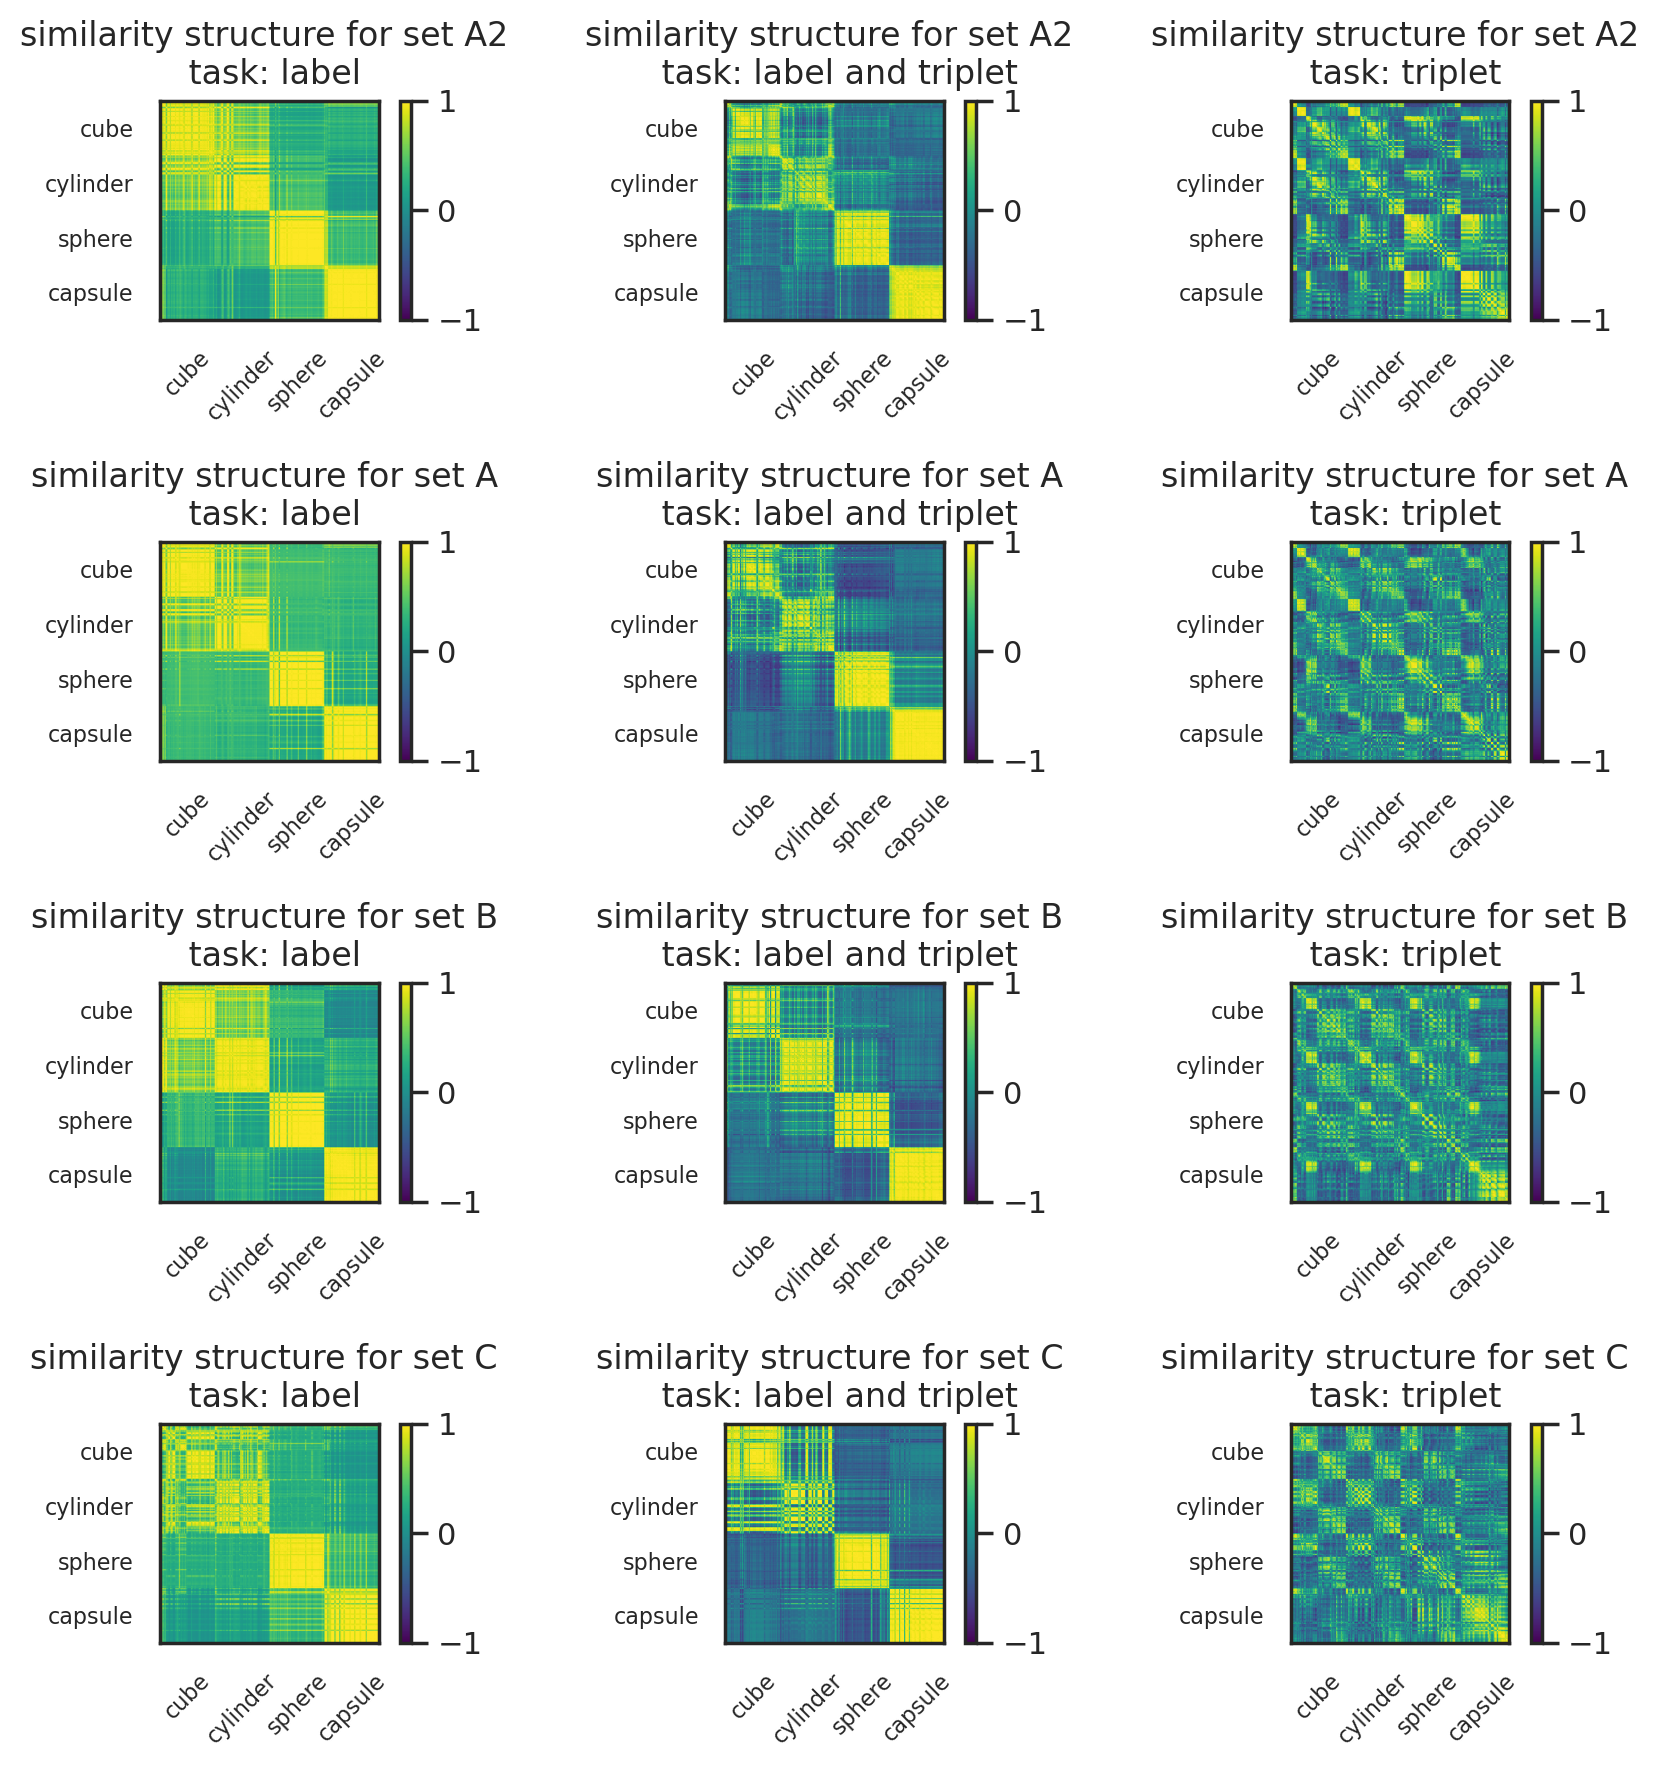

In [18]:
### load in each model and compute the accuracy on the validation set


accs = []
tasks = []
dsets = []
latents_df =pd.DataFrame(columns=['dataset','task','latent'])
fig, axes = plt.subplots(4,3,figsize=(9,9))

for i, this_model in enumerate(model_list):
    ax = axes.flatten()[i]
    nn_model.load_state_dict(torch.load(os.path.join(results_dir,this_model)))
    # nn_model.load_state_dict(torch.load(cifar_model))
    ### pass v_ims through the model but make sure to transpose the image dimensions first
    v_ims_t = torch.from_numpy(v_ims.transpose(0,3,1,2)).float()
    v_ims_t = v_ims_t/255.0
    v_ims_t = Resize(32)(v_ims_t)

    ### now pass v_ims through the model
    latents, labels = nn_model(v_ims_t)

    ### do an argmax on the labels to get the predicted labels
    pred_labels = torch.argmax(labels,dim=1)
    pred_labels = pred_labels.detach().numpy()

    correct = 0
    for j in range(len(pred_labels)):
        if pred_labels[j] == v_labels[j]:
            correct += 1
    # print(correct/len(pred_labels))
    accs.append(correct/len(pred_labels))
    tasks.append(this_model.split('_', 2)[2].rsplit('_', 1)[0])
    dsets.append(this_model.split("_")[1])


    # Compute pairwise cosine similarities
    cos_sim = cosine_similarity(latents.detach().numpy())

    # Plot heatmap
    im = ax.imshow(cos_sim, cmap='viridis', vmin=-1, vmax=1)
    cbar = ax.figure.colorbar(im, ax=ax,fraction=0.046, pad=0.04)
    cbar.set_ticks([-1,0,1])


    ax.set_xticks([60,180,300,420],['cube','cylinder','sphere','capsule'], rotation=45, fontsize=8)
    ax.set_yticks([60,180,300,420],['cube','cylinder','sphere','capsule'],fontsize=8)



    task_string = this_model.split('_', 2)[2]
    task_string = task_string.rsplit('_', 1)[0].replace('_', ' ')


   
    ax.set_title(f'similarity structure for set {this_model.split("_")[1]} \n task: {task_string}')
    fig.tight_layout()

    latents_df.loc[i,'dataset'] = this_model.split("_")[1]
    latents_df.loc[i,'task'] = task_string.replace(' ', '_')
    latents_df.loc[i,'latent'] = latents.detach().numpy()
    

plt.show()
acc_df = pd.DataFrame({'task':tasks,'accuracy':accs,'dataset':dsets})



In [19]:
sns.set_theme(style="white")

In [20]:
acc_df.head()

,task,accuracy,dataset
0,label,0.910417,A2
1,label_and_triplet,0.912500,A2
2,triplet,0.327083,A2
3,label,0.908333,A
4,label_and_triplet,0.906250,A


(0.0, 1.0)

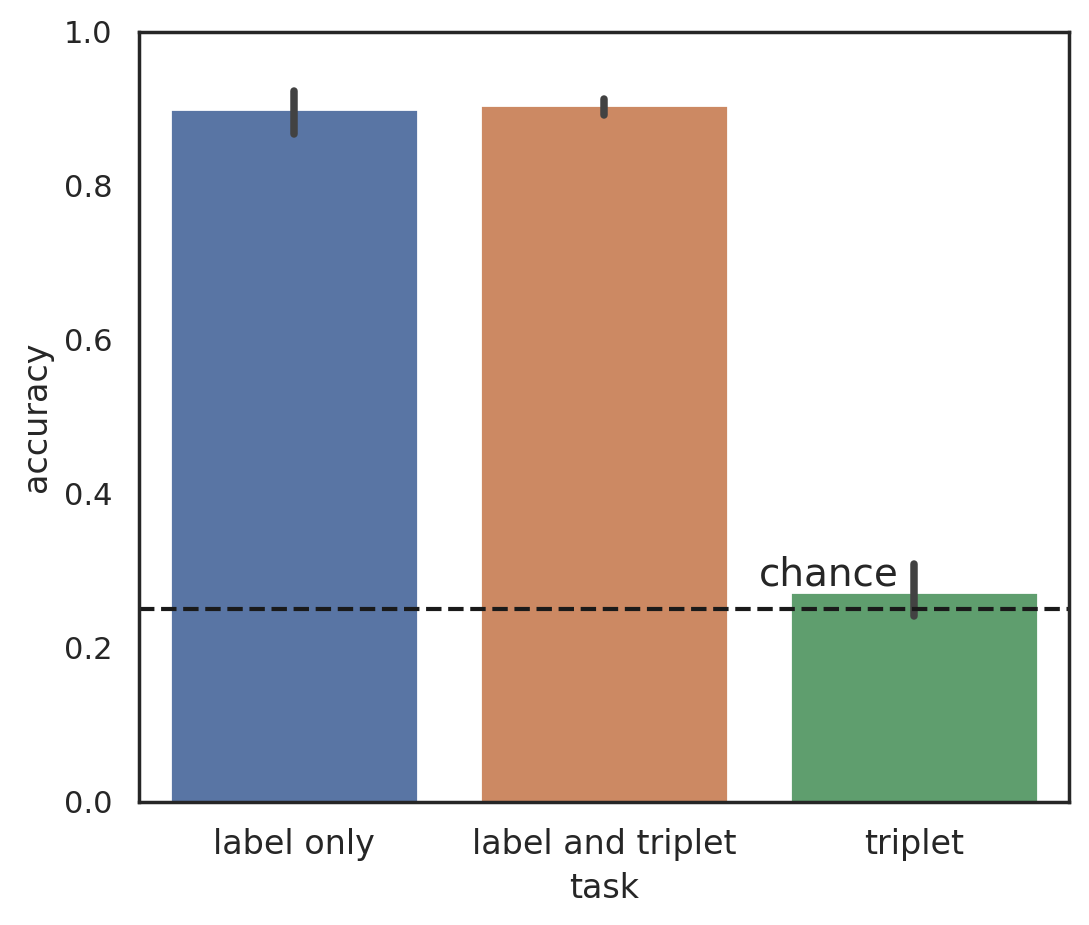

In [21]:
plt.figure(figsize=(6,5))
sns.barplot(x='task',y='accuracy',data=acc_df)
## add a horizontal line at 0.25 and annotate it with the word 'chance'
plt.axhline(0.25,ls='--',color='k')
plt.text(1.5,0.28,'chance',fontsize=14)

### set the x tick labels to be the task names
plt.xticks(range(3),['label only','label and triplet','triplet'],fontsize=12)
plt.ylim([0,1])


In [43]:
# latents_df = latents_df[latents_df['task']!='label']
latents_df.head()



(480, 64)

In [45]:

from scipy.spatial import procrustes

tasks=[]
overlaps = []
withins = []
betweens = []
procruses = []
for this_task in latents_df['task'].unique():
   ds = latents_df[latents_df['task']==this_task]

   distA = pdist(ds[ds.dataset=='A']['latent'].values[0], metric='cosine')
   distA2 = pdist(ds[ds.dataset=='A2']['latent'].values[0], metric='cosine')
   distB = pdist(ds[ds.dataset=='B']['latent'].values[0], metric='cosine')
   distC = pdist(ds[ds.dataset=='C']['latent'].values[0], metric='cosine')

   blocksize = 120
   block_diag = np.zeros((480,480))
   for i in range(4):
      block_diag[i*blocksize:(i+1)*blocksize,i*blocksize:(i+1)*blocksize] = 1

   ### mask distA with block_diag
   within_distA = squareform(distA)*block_diag
   between_distA = squareform(distA)*(1-block_diag)
   within_distA2 = squareform(distA2)*block_diag
   between_distA2 = squareform(distA2)*(1-block_diag)
   within_distB = squareform(distB)*block_diag
   between_distB = squareform(distB)*(1-block_diag)
   within_distC = squareform(distC)*block_diag
   between_distC = squareform(distC)*(1-block_diag)




   ### compute distance matrices and get lower triangles
   dmatA_within = np.tril(within_distA,k=-1).flatten()
   dmatA2_within = np.tril(within_distA2,k=-1).flatten()
   dmatB_within = np.tril(within_distB,k=-1).flatten()
   dmatC_within = np.tril(within_distC,k=-1).flatten()
 

   dmatA_between = np.tril(between_distA,k=-1).flatten()
   dmatA2_between = np.tril(between_distA2,k=-1).flatten()
   dmatB_between = np.tril(between_distB,k=-1).flatten()
   dmatC_between = np.tril(between_distC,k=-1).flatten()


   # AB_sim = np.corrcoef(dmatA,dmatB)[0,1]
   # AC_sim = np.corrcoef(dmatA,dmatC)[0,1]
   # BC_sim = np.corrcoef(dmatB,dmatC)[0,1]
   AB_proc = procrustes(ds[ds.dataset=='A']['latent'].values[0], ds[ds.dataset=='B']['latent'].values[0] )[2]
   AC_proc = procrustes(ds[ds.dataset=='A']['latent'].values[0], ds[ds.dataset=='C']['latent'].values[0] )[2]
   BC_proc = procrustes(ds[ds.dataset=='B']['latent'].values[0], ds[ds.dataset=='C']['latent'].values[0] )[2]
   AA_proc = procrustes(ds[ds.dataset=='A']['latent'].values[0], ds[ds.dataset=='A2']['latent'].values[0] )[2]

   AB_within_sim = np.corrcoef(dmatA_within,dmatB_within)[0,1]
   AC_within_sim = np.corrcoef(dmatA_within,dmatC_within)[0,1]
   BC_within_sim = np.corrcoef(dmatB_within,dmatC_within)[0,1]
   AA_within_sim = np.corrcoef(dmatA_within,dmatA2_within)[0,1]

   AB_between_sim = np.corrcoef(dmatA_between,dmatB_between)[0,1]
   AC_between_sim = np.corrcoef(dmatA_between,dmatC_between)[0,1]
   BC_between_sim = np.corrcoef(dmatB_between,dmatC_between)[0,1]
   AA_between_sim = np.corrcoef(dmatA_between,dmatA2_between)[0,1]

   # print(f'{this_task} results')
   # print(f'AA within category similarity for {this_task} is {AA_within_sim}')
   # print(f'AB within category similarity for {this_task} is {AB_within_sim}')
   # print(f'AC within category similarity for {this_task} is {AC_within_sim}')
   # print(f'BC within category similarity for {this_task} is {BC_within_sim}')
   # print('')
   # print(f'AA between category similarity for {this_task} is {AA_between_sim}')
   # print(f'AB between category similarity for {this_task} is {AB_between_sim}')
   # print(f'AC between category similarity for {this_task} is {AC_between_sim}')
   # print(f'BC between category similarity for {this_task} is {BC_between_sim}')
   # print('')
   tasks.append([this_task]*4)
   overlaps.append([50,0,33.33,100])
   withins.append([AB_within_sim,AC_within_sim,BC_within_sim,AA_within_sim])
   betweens.append([AB_between_sim,AC_between_sim,BC_between_sim,AA_between_sim])
   procruses.append([AB_proc,AC_proc,BC_proc,AA_proc])






In [47]:
sim_df = pd.DataFrame({'task':np.array(tasks).flatten(), 'overlap':np.array(overlaps).flatten(),'within':np.array(withins).flatten(),'between':np.array(betweens).flatten(), 'procrustes':np.array(procruses).flatten()})
sim_df

,task,overlap,within,between,procrustes
0,label,50.00,0.525616,0.938960,0.266970
1,label,0.00,0.354699,0.917394,0.405322
2,label,33.33,0.457293,0.921879,0.343257
3,label,100.00,0.686631,0.938674,0.210756
4,label_and_triplet,50.00,0.447196,0.910670,0.391458
5,label_and_triplet,0.00,0.492352,0.916051,0.436577
6,label_and_triplet,33.33,0.369781,0.930335,0.349572
7,label_and_triplet,100.00,0.660320,0.937167,0.327316
8,triplet,50.00,0.876681,0.874984,0.634676
9,triplet,0.00,0.839155,0.829417,0.839706


In [48]:

sim_df = pd.melt(sim_df, id_vars=['task','overlap'], value_vars=['within','between','procrustes'])

sim_df.columns = ['task','overlap','dist_type','alignment']
sim_df

,task,overlap,dist_type,alignment
0,label,50.00,within,0.525616
1,label,0.00,within,0.354699
2,label,33.33,within,0.457293
3,label,100.00,within,0.686631
4,label_and_triplet,50.00,within,0.447196
5,label_and_triplet,0.00,within,0.492352
6,label_and_triplet,33.33,within,0.369781
7,label_and_triplet,100.00,within,0.660320
8,triplet,50.00,within,0.876681
9,triplet,0.00,within,0.839155


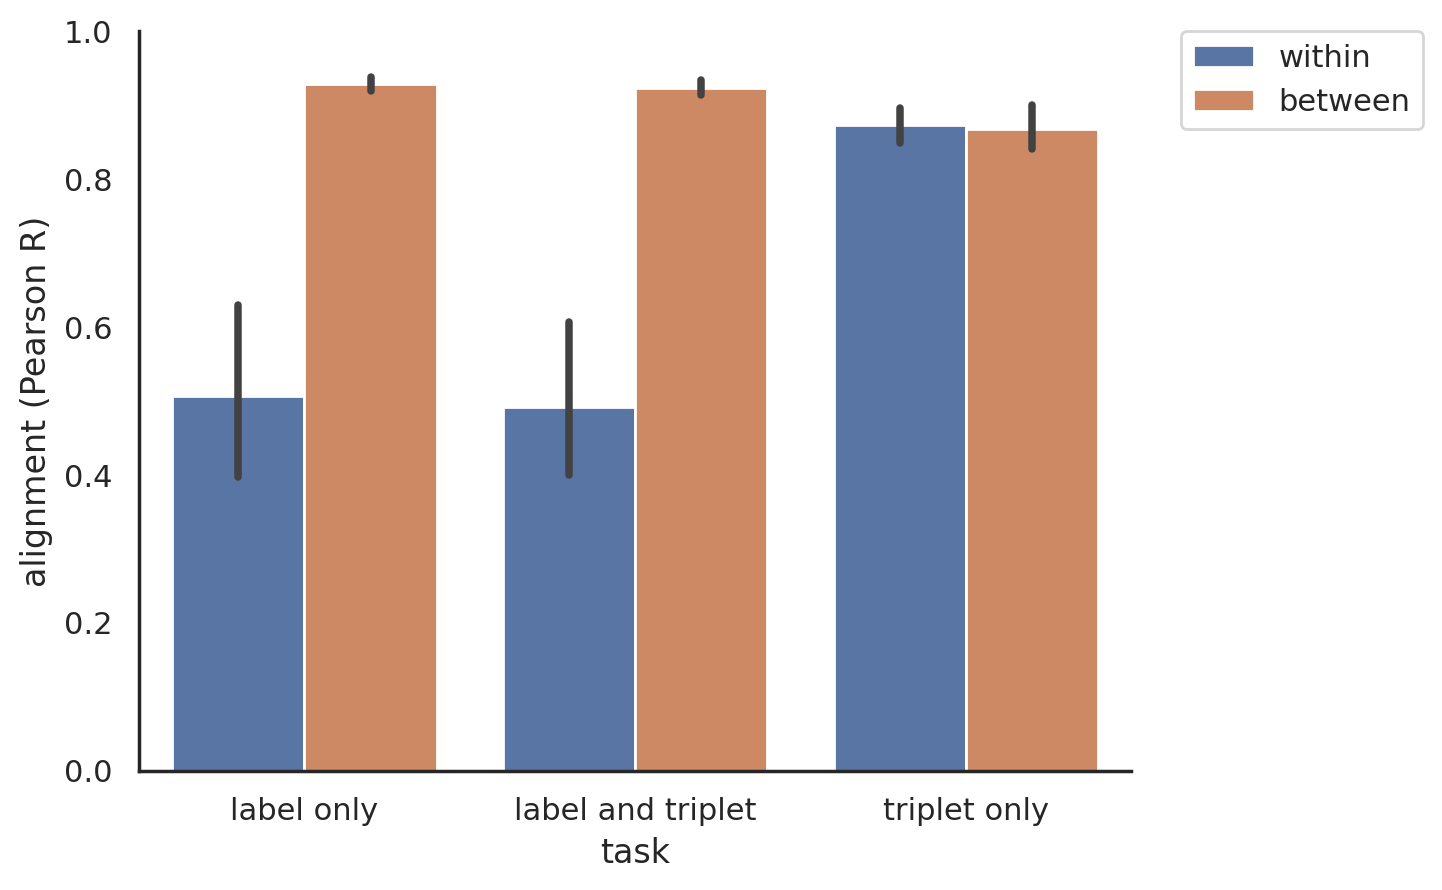

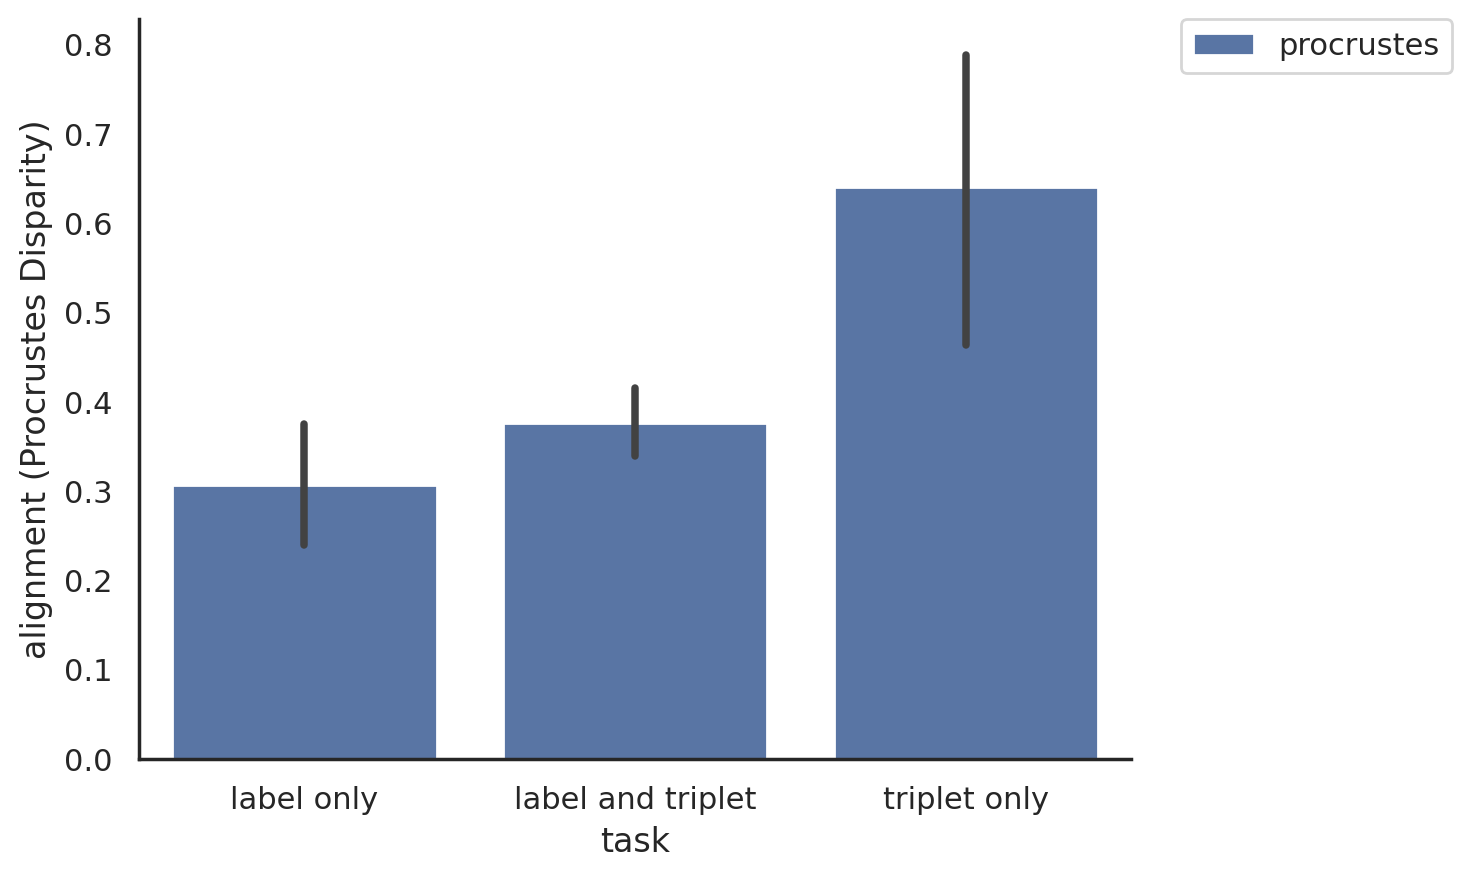

In [55]:

sns.set_theme(style="white")
sns.barplot(x="task", y="alignment", hue="dist_type", hue_order=['within','between' ], data=sim_df)
sns.despine()
### move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('alignment (Pearson R)')
plt.xticks([0,1,2],['label only','label and triplet', 'triplet only'])
plt.ylim([0,1])
plt.show()
sns.barplot(x="task", y="alignment", hue="dist_type", hue_order=['procrustes'], data=sim_df)
sns.despine()
### move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('alignment (Procrustes Disparity)')
plt.xticks([0,1,2],['label only','label and triplet', 'triplet only'])
# plt.ylim([0,1])
plt.show()

/mnt/ws/home/kmukherjee/miniconda3/envs/sketch_tools/lib/python3.8/site-packages/seaborn/axisgrid.py:717: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


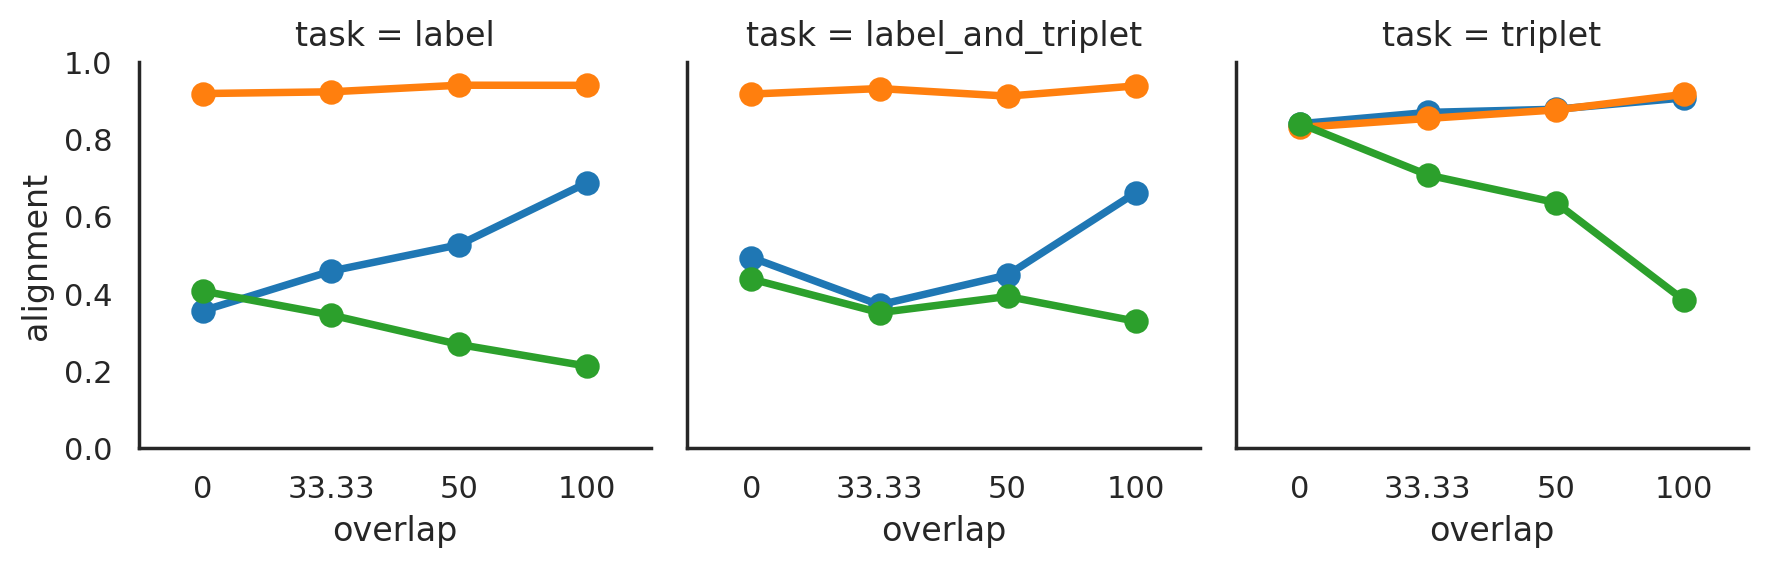

In [53]:
sns.set_theme(style="white")
# sns.pointplot(x="overlap", y="similarity", hue='category', data=sim_df)
# plt.ylim([0,1])
g = sns.FacetGrid(sim_df,  col="task", margin_titles=True)
g.map(sns.pointplot, "overlap", "alignment", "dist_type", order=[0,33.33,50,100],palette='tab10')
g.set(ylim=(0, 1))
